/tmp/ipykernel_904478/1520600971.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  basket_df[f"{a}_sig" ].fillna(0, inplace=True)
/tmp/ipykernel_904478/1520600971.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 


================  DAILY TRADING LOG  ================

2025-01-02  |  FLAT  |  NAV stays 10,000.00
2025-01-03 | CITI  | LONG  | 5,325.58$ | ret +1.52% -> pnl +80.71
2025-01-03 | BRENT | LONG  | 4,674.42$ | ret +0.76% -> pnl +35.71
2025-01-06 | BRENT | LONG  | 10,116.42$ | ret -0.27% -> pnl -27.77
2025-01-07 | CITI  | LONG  | 6,114.92$ | ret +1.29% -> pnl +79.02
2025-01-07 | BRENT | LONG  | 3,973.74$ | ret +0.98% -> pnl +39.06
2025-01-08 | BRENT | LONG  | 10,206.73$ | ret -1.16% -> pnl -117.90
2025-01-09 | BRENT | LONG  | 10,088.84$ | ret +1.00% -> pnl +100.68
2025-01-10 | CITI  | SHORT | 3,481.18$ | ret -2.54% -> pnl +88.38
2025-01-10 | BRENT | LONG  | 6,708.34$ | ret +3.69% -> pnl +247.68
2025-01-13 | BRENT | LONG  | 10,525.58$ | ret +1.57% -> pnl +164.96
2025-01-14  |  FLAT  |  NAV stays 10,690.54
2025-01-15 | CITI  | LONG  | 5,968.18$ | ret +6.49% -> pnl +387.32
2025-01-15 | BRENT | LONG  | 4,722.36$ | ret +2.64% -> pnl +124.68
2025-01-16 | CITI  | LONG  | 11,202.54$ | ret +0.31% -

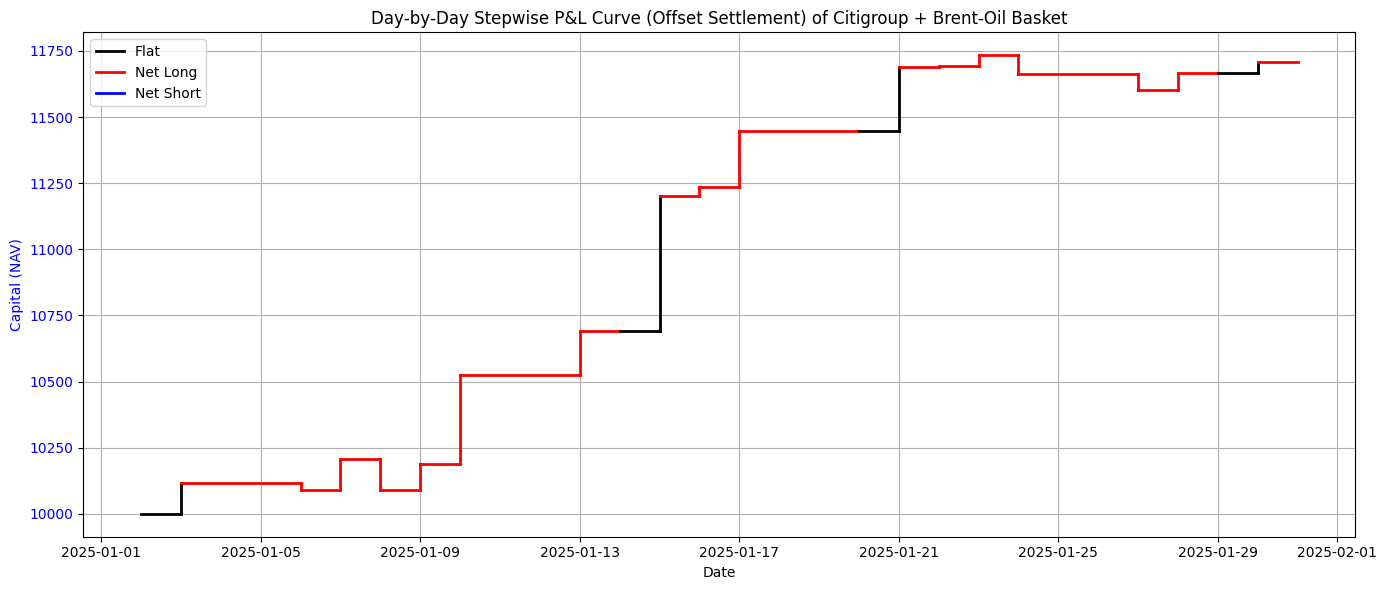

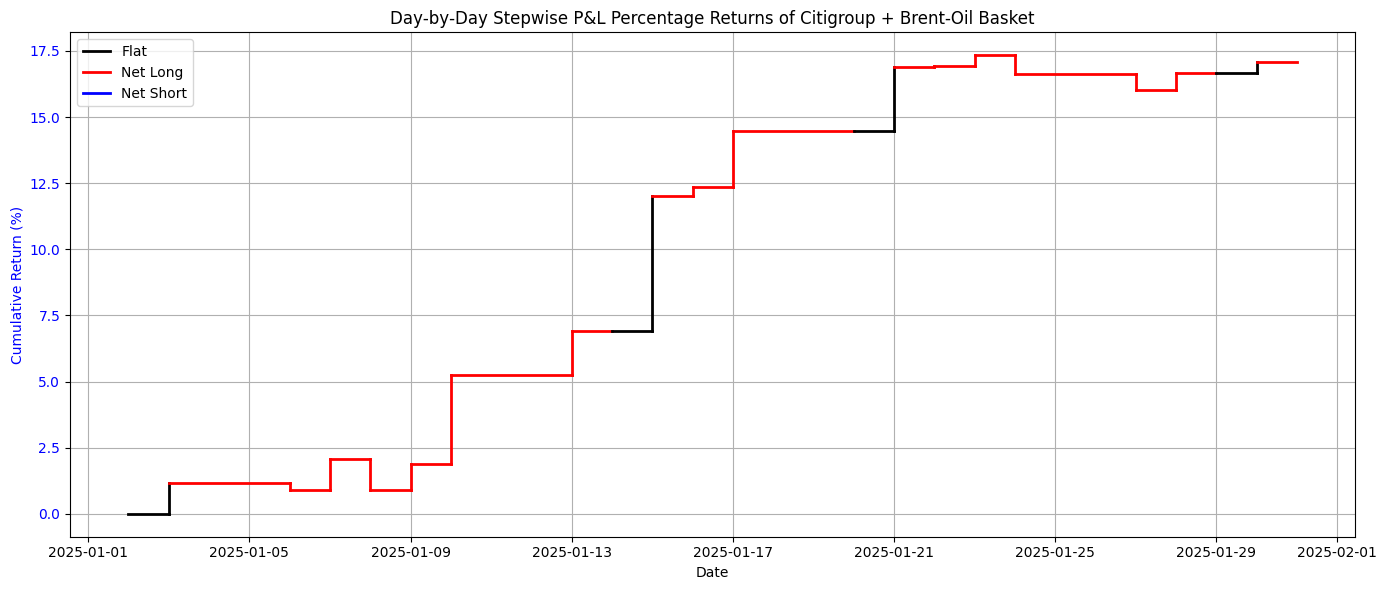

In [6]:
###############################################################################
# basket_trade_two_assets.py  –  Jan‑2025 Citigroup + Brent‑Oil basket trading
###############################################################################
import numpy as np                               # ← NEW
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt                  # ← NEW
from matplotlib.lines import Line2D              # ← NEW

# --------------------------------------------------------------------------- #
# 0) CONFIGURATION                                                            #
# --------------------------------------------------------------------------- #
INIT_NAV     = 10_000           # initial portfolio value
MAX_WEIGHT   = 0.75             # cap per‑asset weight (optional risk‑guard)
ASSETS = {                       # filenames for each asset
    "citi":  dict(sig="signals_citi.csv",
                  conf="confidence_citi.csv",
                  ret="returns_citi.csv"),
    "brent": dict(sig="signals_brentoil.csv",
                  conf="confidence_brentoil.csv",
                  ret="returns_brentoil.csv")
}
OUT_BASKET_NAV = "basket_nav_jan25.csv"
# --------------------------------------------------------------------------- #

def _load_col(fname: str, colname: str) -> pd.Series:
    """Load CSV and return <colname> as a date‑indexed Series."""
    s = (pd.read_csv(fname, parse_dates=["date"])
          .set_index("date")[colname])
    if not s.index.is_monotonic_increasing:
        s = s.sort_index()
    return s

# -------- 1) load & merge the three feeds per asset ------------------------ #
frames = []
for asset, f in ASSETS.items():
    sig  = _load_col(f["sig"],  "signal").rename(f"{asset}_sig")
    conf = _load_col(f["conf"], "conf"  ).rename(f"{asset}_conf")
    ret  = _load_col(f["ret"],  "ret"   ).rename(f"{asset}_ret")
    frames.append(pd.concat([sig, conf, ret], axis=1))

basket_df = pd.concat(frames, axis=1).loc["2025-01-01":"2025-01-31"]
basket_df = basket_df.sort_index()

# ---------- sanitise missing data ------------------------------------------
for a in ASSETS:
    basket_df[f"{a}_sig" ].fillna(0, inplace=True)
    basket_df[f"{a}_conf"].fillna(0, inplace=True)
    basket_df[f"{a}_ret" ].fillna(0, inplace=True)

# -------- 2) back‑test loop ------------------------------------------------ #
nav_hist  = []
trade_log = []
nav       = INIT_NAV

for dt, row in basket_df.iterrows():
    active = [a for a in ASSETS if row[f"{a}_sig"] != 0]

    if not active:
        nav_hist.append({"date": dt, "nav": nav, "sig": 0})
        trade_log.append(f"{dt.date()}  |  FLAT  |  NAV stays {nav:,.2f}")
        continue

    # ---- 2a) weights -------------------------------------------------------
    confs    = {a: row[f"{a}_conf"] for a in active}
    tot_conf = sum(confs.values())

    if tot_conf <= 0 or np.isnan(tot_conf):
        weights = {a: 1/len(active) for a in active}
    else:
        weights = {a: min(confs[a] / tot_conf, MAX_WEIGHT) for a in active}
        scale   = 1 / sum(weights.values())
        weights = {a: w*scale for a, w in weights.items()}

    # ---- 2b) PnL -----------------------------------------------------------
    daily_pnl = 0.0
    net_sig   = 0.0
    for a in active:
        capital_i = nav * weights[a]
        pnl_i     = capital_i * row[f"{a}_sig"] * row[f"{a}_ret"]
        daily_pnl += pnl_i
        net_sig   += weights[a] * row[f"{a}_sig"]

        trade_log.append(
            f"{dt.date()} | {a.upper():5s} | "
            f"{'LONG' if row[f'{a}_sig']>0 else 'SHORT':5s} | "
            f"{capital_i:,.2f}$ | ret {row[f'{a}_ret']*100:+.2f}% -> pnl {pnl_i:+.2f}"
        )

    nav += daily_pnl
    net_sig_val = np.sign(net_sig) if not np.isnan(net_sig) else 0
    nav_hist.append({"date": dt, "nav": nav, "sig": int(net_sig_val)})

# -------- 3) results to CSV + console summary ------------------------------ #
nav_df = pd.DataFrame(nav_hist).set_index("date")
nav_df["cum_ret_%"] = 100 * (nav_df["nav"] / INIT_NAV - 1)
nav_df.to_csv(OUT_BASKET_NAV, float_format="%.6f")

print("\n================  DAILY TRADING LOG  ================\n")
for line in trade_log:
    print(line)

final_ret = nav_df["cum_ret_%"].iloc[-1]
print("\n================  SUMMARY  ==========================")
print(f"Final NAV:  {nav_df['nav'].iloc[-1]:,.2f}  "
      f" ({final_ret:+.2f} %)   — written to {OUT_BASKET_NAV}")

# --------------------------------------------------------------------------- #
# 4) PLOT THE TWO REQUESTED DIAGRAMS                                          #
# --------------------------------------------------------------------------- #
def _step_plot_core(ax, x, y, sig):
    """Draw horizontal‑then‑vertical steps coloured by position signal."""
    colour = {1: "red", -1: "blue", 0: "black"}
    for i in range(1, len(x)):
        c = colour.get(sig[i-1], "black")
        # horizontal segment
        ax.plot([x[i-1], x[i]], [y[i-1], y[i-1]], color=c, lw=2)
        # vertical jump
        ax.plot([x[i], x[i]], [y[i-1], y[i]],   color=c, lw=2)

def plot_stepwise_nav_curve(navdf: pd.DataFrame, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(14,6))
    dates = navdf.index.to_pydatetime()
    _step_plot_core(ax1, dates, navdf["nav"].values, navdf["sig"].values)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Capital (NAV)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    legend_elems = [
        Line2D([0],[0], color='black', lw=2, label='Flat'),
        Line2D([0],[0], color='red',   lw=2, label='Net Long'),
        Line2D([0],[0], color='blue',  lw=2, label='Net Short')
    ]
    ax1.legend(handles=legend_elems, loc="upper left")
    ax1.set_title(f"Day‑by‑Day Stepwise P&L Curve (Offset Settlement) {title_suffix}")
    plt.tight_layout()
    plt.show()

def plot_stepwise_pct_curve(navdf: pd.DataFrame, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(14,6))
    dates = navdf.index.to_pydatetime()
    _step_plot_core(ax1, dates, navdf["cum_ret_%"].values, navdf["sig"].values)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Return (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    legend_elems = [
        Line2D([0],[0], color='black', lw=2, label='Flat'),
        Line2D([0],[0], color='red',   lw=2, label='Net Long'),
        Line2D([0],[0], color='blue',  lw=2, label='Net Short')
    ]
    ax1.legend(handles=legend_elems, loc="upper left")
    ax1.set_title(f"Day‑by‑Day Stepwise P&L Percentage Returns {title_suffix}")
    plt.tight_layout()
    plt.show()

# call the two plots
plot_stepwise_nav_curve(nav_df,       "of Citigroup + Brent‑Oil Basket")
plot_stepwise_pct_curve(nav_df,       "of Citigroup + Brent‑Oil Basket")
